In [1]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(123)
import tensorflow as tf
tf.random.set_seed(123)
import os, shutil
from keras import models
from keras import layers
from sklearn.metrics import confusion_matrix, f1_score, recall_score, accuracy_score
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
import keras
from tensorflow.keras.callbacks import EarlyStopping
from keras import optimizers



### Generator

In [2]:
# Directory path
train_data_dir = 'CellData/chest_xray/train'
test_data_dir = 'CellData/chest_xray/test'

# Get all the data in the directory data/validation (624 images), and reshape them
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, 
        target_size=(256, 256), batch_size=624)

# Get all the data in the directory data/train (5232 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, 
        target_size=(256, 256), batch_size=5232)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 624 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.


In [3]:
print(np.shape(train_images))
print(np.shape(train_labels))
print(np.shape(test_images))
print(np.shape(test_labels))

(5232, 256, 256, 3)
(5232, 2)
(624, 256, 256, 3)
(624, 2)


In [4]:
train_generator.class_indices


{'NORMAL': 0, 'PNEUMONIA': 1}

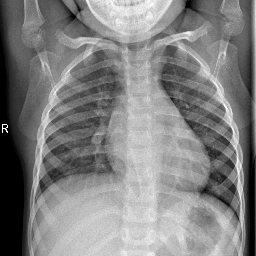

In [5]:
array_to_img(train_images[132])


In [6]:
train_labels[132]


array([1., 0.], dtype=float32)

### Fixing the labels

In [7]:
# fix the labels for the images so that normal=0 and pneumonia=1
y_model = train_labels.T[[1]]
y_test = test_labels.T[[1]]

In [8]:
y_model, y_model.shape

(array([[1., 1., 0., ..., 0., 1., 1.]], dtype=float32), (1, 5232))

In [9]:
# counts for each class
print('Train Class Counts:', np.unique(y_model, return_counts=True))
print('Test Class Counts:', np.unique(y_test, return_counts=True))

Train Class Counts: (array([0., 1.], dtype=float32), array([1349, 3883]))
Test Class Counts: (array([0., 1.], dtype=float32), array([234, 390]))


In [10]:
y_model = y_model.T
y_test = y_test.T

In [11]:
test_images.shape

(624, 256, 256, 3)

### Reshape and standardize images

In [12]:
# reshape the images
train_img_unrow = train_images.reshape(5232, -1)
test_img_unrow = test_images.reshape(624, -1)

In [13]:
test_img_unrow.shape

(624, 196608)

In [14]:
train_img_unrow, train_img_unrow

(array([[ 32.,  32.,  32., ...,   0.,   0.,   0.],
        [ 12.,  12.,  12., ...,  11.,  11.,  11.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [103., 103., 103., ...,   0.,   0.,   0.],
        [  1.,   1.,   1., ...,  22.,  22.,  22.],
        [ 22.,  22.,  22., ...,  20.,  20.,  20.]], dtype=float32),
 array([[ 32.,  32.,  32., ...,   0.,   0.,   0.],
        [ 12.,  12.,  12., ...,  11.,  11.,  11.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [103., 103., 103., ...,   0.,   0.,   0.],
        [  1.,   1.,   1., ...,  22.,  22.,  22.],
        [ 22.,  22.,  22., ...,  20.,  20.,  20.]], dtype=float32))

In [15]:
# standardize data
X_model = train_img_unrow/255
X_test = test_img_unrow/255

In [16]:
X_model.shape, X_test.shape

((5232, 196608), (624, 196608))

### Model building:

#### Model # 1

In [17]:
# split model set into training and validation set
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=0.2, random_state=123)

In [18]:
# function for visualizing loss and accuracy across epochs for training and validation set
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_recall'])
    plt.plot(history['recall'])
    plt.legend(['val_recall', 'recall'])
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.show()

In [19]:
model_1 = Sequential()
model_1.add(layers.Dense(128, activation='tanh', input_shape=(196608,)))
model_1.add(layers.Dense(64, activation='tanh'))
model_1.add(layers.Dense(32, activation='tanh'))
model_1.add(layers.Dense(1, activation='sigmoid'))

In [20]:
model_1.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy', keras.metrics.Recall()])


In [21]:
results_1 = model_1.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))


Epoch 1/10
66/66 [==============================] - 10s 154ms/step - loss: 0.6797 - accuracy: 0.6648 - recall: 0.8480 - val_loss: 0.5543 - val_accuracy: 0.7421 - val_recall: 1.0000
Epoch 2/10
66/66 [==============================] - 7s 110ms/step - loss: 0.5365 - accuracy: 0.7422 - recall: 1.0000 - val_loss: 0.5576 - val_accuracy: 0.7421 - val_recall: 1.0000
Epoch 3/10
66/66 [==============================] - 7s 108ms/step - loss: 0.5371 - accuracy: 0.7422 - recall: 1.0000 - val_loss: 0.4729 - val_accuracy: 0.7421 - val_recall: 1.0000
Epoch 4/10
66/66 [==============================] - 7s 109ms/step - loss: 0.4840 - accuracy: 0.7422 - recall: 1.0000 - val_loss: 0.5154 - val_accuracy: 0.7421 - val_recall: 1.0000
Epoch 5/10
66/66 [==============================] - 7s 109ms/step - loss: 0.4634 - accuracy: 0.7668 - recall: 0.9936 - val_loss: 0.4634 - val_accuracy: 0.7421 - val_recall: 1.0000
Epoch 6/10
66/66 [==============================] - 7s 109ms/step - loss: 0.4197 - accuracy: 0.8096

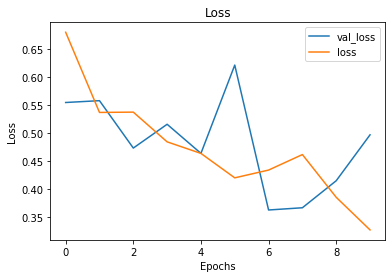

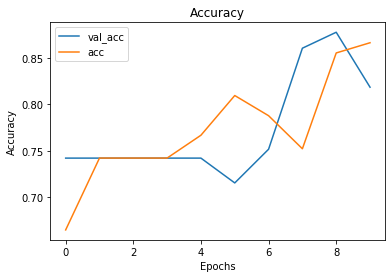

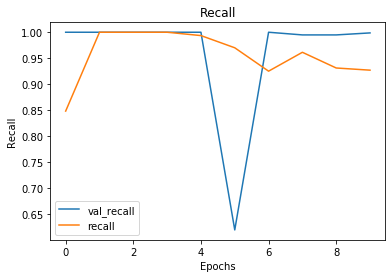

In [22]:
# change in loss and accuracy for training and validation set per epoch
visualize_training_results(results_1)


In [23]:
# evaluate training and test sets
results_train = model_1.evaluate(X_train, y_train)
results_test = model_1.evaluate(X_test, y_test)
print(results_train, results_test)

20/20 [==============================] - 0s 23ms/step - loss: 0.9568 - accuracy: 0.6651 - recall: 1.0000
[0.5077478885650635, 0.8112305998802185, 0.9987121820449829] [0.9567636251449585, 0.6650640964508057, 1.0]


#### Model #2

In [24]:
# Directory path
train_data_dir = 'CellData/chest_xray/train'
test_data_dir = 'CellData/chest_xray/test'

# Get all the data in the directory data/validation (624 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_data_dir, 
        target_size=(256, 256), batch_size=624)

# Get all the data in the directory data/train (5232 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_data_dir, 
        target_size=(256, 256), batch_size=5232)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 624 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.


In [25]:
train_labels.shape

(5232, 2)

In [26]:
test_labels.shape

(624, 2)

In [27]:
train_labels = np.reshape(train_labels[:,1], (5232,1))
test_labels = np.reshape(test_labels[:,1], (624,1))

In [28]:
train_labels

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [1.]], dtype=float32)

In [29]:
test_labels

array([[1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],

In [30]:
y_train.shape

(4185, 1)

In [31]:
test_labels.shape, train_labels.shape

((624, 1), (5232, 1))

In [32]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.20, random_state=123)

In [33]:
#y_train = np.asarray(train_labels).astype('float32').reshape((-1,1))
#y_val = np.asarray(test_labels).astype('float32').reshape((-1,1))

In [34]:
cnn = models.Sequential()
cnn.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256,  3)))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(32, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))

cnn.compile(loss='binary_crossentropy',
              optimizer = "Adam",
              metrics=['accuracy', 'Recall'])

In [35]:
cnn1 = cnn.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=50,
                    validation_data=(X_val, y_val),
                      workers = -1)

Epoch 1/10
84/84 [==============================] - 70s 832ms/step - loss: 0.5613 - accuracy: 0.7157 - recall: 0.9317 - val_loss: 0.3119 - val_accuracy: 0.7450 - val_recall: 1.0000
Epoch 2/10
84/84 [==============================] - 68s 807ms/step - loss: 0.2694 - accuracy: 0.8401 - recall: 0.9881 - val_loss: 0.2424 - val_accuracy: 0.9389 - val_recall: 0.9923
Epoch 3/10
84/84 [==============================] - 67s 802ms/step - loss: 0.2472 - accuracy: 0.9410 - recall: 0.9733 - val_loss: 0.2202 - val_accuracy: 0.9589 - val_recall: 0.9923
Epoch 4/10
84/84 [==============================] - 68s 804ms/step - loss: 0.2063 - accuracy: 0.9665 - recall: 0.9839 - val_loss: 0.2081 - val_accuracy: 0.9656 - val_recall: 0.9833
Epoch 5/10
84/84 [==============================] - 67s 803ms/step - loss: 0.1951 - accuracy: 0.9661 - recall: 0.9816 - val_loss: 0.1996 - val_accuracy: 0.9666 - val_recall: 0.9846
Epoch 6/10
84/84 [==============================] - 67s 794ms/step - loss: 0.1819 - accuracy: 0

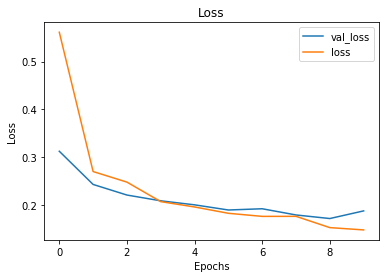

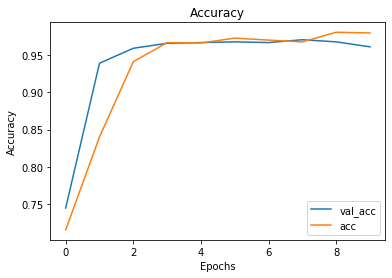

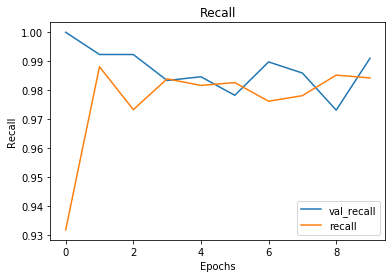

In [36]:
visualize_training_results(cnn1)


In [37]:
## Test set:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4185, 256, 256, 3), (4185, 1), (624, 196608), (624, 1))

In [38]:
results_train = cnn.evaluate(X_train, y_train)
results_test = cnn.evaluate(test_images, y_test)
print(results_train, results_test) ## loss, accuracy, recall

20/20 [==============================] - 3s 133ms/step - loss: 2.7557 - accuracy: 0.5994 - recall: 0.8359
[0.14097438752651215, 0.9770609140396118, 0.9916210174560547] [2.755687713623047, 0.5993589758872986, 0.8358974456787109]


It seems like our model is doing well in the training set but not as well in the test set. I can see that it is not performing so well on the test set so  I wil l try to add more complexitiy  

In [39]:
# How to improve our model?
# How to deal with class imbalance ? (data augmentation vs downsample/upsample)

## baseline model - during preprocessing before resampling
## DROP OUT, lasso-ridge, augment images (throw away)

### 2nd CNN Model:

In [40]:
# Directory path
train_data_dir = 'CellData/chest_xray/train'
test_data_dir = 'CellData/chest_xray/test'

# Get all the data in the directory data/validation (624 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_data_dir, 
        target_size=(256, 256), batch_size=624)

# Get all the data in the directory data/train (5232 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_data_dir, 
        target_size=(256, 256), batch_size=5232)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 624 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.


In [41]:
train_labels = np.reshape(train_labels[:,1], (5232,1))
test_labels = np.reshape(test_labels[:,1], (624,1))

In [42]:
train_labels.shape, test_labels.shape

((5232, 1), (624, 1))

In [43]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.20, random_state=123)

In [44]:
cnn_2 = models.Sequential()
cnn_2.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256,  3)))
cnn_2.add(layers.MaxPooling2D((2, 2)))
cnn_2.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_2.add(layers.MaxPooling2D((2, 2)))
cnn_2.add(layers.Conv2D(64, (3, 3), activation='selu', input_shape=(256, 256,  3)))
cnn_2.add(layers.MaxPooling2D((2, 2)))
cnn_2.add(layers.Flatten())
cnn_2.add(layers.Dense(32, activation='relu'))
cnn_2.add(layers.Dense(1, activation='sigmoid'))

cnn_2.compile(loss='binary_crossentropy',
              optimizer = "Adam",
              metrics=['accuracy', 'Recall'])

In [45]:
cnn2 = cnn_2.fit(X_train,
                 y_train,
                 epochs=10,
                 batch_size=50,
                 validation_data=(X_val, y_val),
                 workers = -1)

Epoch 1/10
84/84 [==============================] - 82s 979ms/step - loss: 0.4099 - accuracy: 0.8368 - recall: 0.9280 - val_loss: 0.2578 - val_accuracy: 0.8968 - val_recall: 0.8623
Epoch 2/10
84/84 [==============================] - 81s 964ms/step - loss: 0.1404 - accuracy: 0.9515 - recall: 0.9704 - val_loss: 0.0885 - val_accuracy: 0.9713 - val_recall: 0.9740
Epoch 3/10
84/84 [==============================] - 82s 971ms/step - loss: 0.1019 - accuracy: 0.9654 - recall: 0.9772 - val_loss: 0.3250 - val_accuracy: 0.8749 - val_recall: 0.8299
Epoch 4/10
84/84 [==============================] - 80s 953ms/step - loss: 0.0968 - accuracy: 0.9625 - recall: 0.9733 - val_loss: 0.0729 - val_accuracy: 0.9733 - val_recall: 0.9740
Epoch 5/10
84/84 [==============================] - 80s 955ms/step - loss: 0.0832 - accuracy: 0.9699 - recall: 0.9782 - val_loss: 0.0712 - val_accuracy: 0.9723 - val_recall: 0.9740
Epoch 6/10
84/84 [==============================] - 80s 956ms/step - loss: 0.0830 - accuracy: 0

In [46]:
results_train = cnn_2.evaluate(X_train, y_train)
results_test = cnn_2.evaluate(test_images, y_test)
print(results_train, results_test) ## loss, accuracy, recall

20/20 [==============================] - 3s 159ms/step - loss: 3.7574 - accuracy: 0.5353 - recall: 0.7282
[0.02611231431365013, 0.9925925731658936, 0.9929328560829163] [3.757366418838501, 0.5352563858032227, 0.728205144405365]


In [47]:
cnn2.history

{'loss': [0.40988948941230774,
  0.1404033899307251,
  0.10187327861785889,
  0.09681210666894913,
  0.08318310230970383,
  0.08296224474906921,
  0.07148942351341248,
  0.05715598165988922,
  0.046335168182849884,
  0.04438767954707146],
 'accuracy': [0.8367980718612671,
  0.9514934420585632,
  0.965352475643158,
  0.9624850749969482,
  0.9698925018310547,
  0.9713261723518372,
  0.9729987978935242,
  0.9792114496231079,
  0.9832736253738403,
  0.9837514758110046],
 'recall': [0.9280436635017395,
  0.9704465270042419,
  0.9771924018859863,
  0.9733375906944275,
  0.9781560897827148,
  0.9810472130775452,
  0.9816896915435791,
  0.9855445027351379,
  0.9871506690979004,
  0.9897205233573914],
 'val_loss': [0.25779446959495544,
  0.08853885531425476,
  0.3249540328979492,
  0.07292164117097855,
  0.07123798877000809,
  0.0942147821187973,
  0.07244488596916199,
  0.06383795291185379,
  0.09445387125015259,
  0.06438196450471878],
 'val_accuracy': [0.8968481421470642,
  0.971346676349639

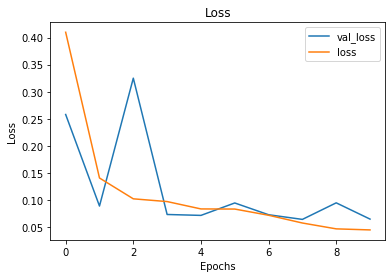

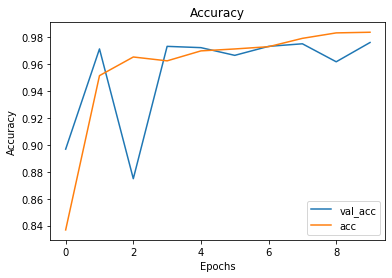

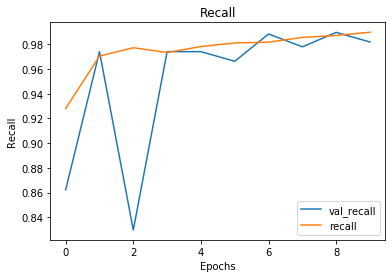

In [48]:
visualize_training_results(cnn2)


### Model #3:

In [49]:
# Directory path
train_data_dir = 'CellData/chest_xray/train'
test_data_dir = 'CellData/chest_xray/test'

# Get all the data in the directory data/validation (624 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_data_dir, 
        target_size=(256, 256), batch_size=624)

# Get all the data in the directory data/train (5232 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_data_dir, 
        target_size=(256, 256), batch_size=5232)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 624 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.


In [50]:
train_labels = np.reshape(train_labels[:,1], (5232,1))
test_labels = np.reshape(test_labels[:,1], (624,1))

In [51]:
train_labels.shape, test_labels.shape

((5232, 1), (624, 1))

In [52]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.20, random_state=123)

In [53]:
# model fit
cnn_3 = models.Sequential()
cnn_3.add(layers.Conv2D(32, 3, activation = 'relu', input_shape=(256, 256, 3)))
cnn_3.add(layers.MaxPooling2D((2, 2)))
cnn_3.add(layers.Conv2D(64, 3, activation = 'relu'))
cnn_3.add(layers.MaxPooling2D((2, 2)))
cnn_3.add(layers.Conv2D(128, 3, activation = 'relu'))
cnn_3.add(layers.MaxPooling2D((2, 2)))
cnn_3.add(layers.Flatten())
cnn_3.add(layers.Dense(256, activation = 'relu'))
cnn_3.add(layers.Dense(1, activation='sigmoid'))

In [54]:
cnn_3.compile(loss='binary_crossentropy',
              optimizer = "Adam",
              metrics=['accuracy', 'Recall'])

In [55]:
cnn3 = cnn_3.fit(X_train,
                 y_train,
                 epochs=10,
                 batch_size=50,
                 validation_data=(X_val, y_val),
                 workers = -1)

Epoch 1/10
84/84 [==============================] - 163s 2s/step - loss: 0.4098 - accuracy: 0.8779 - recall: 0.9313 - val_loss: 0.1009 - val_accuracy: 0.9713 - val_recall: 0.9766
Epoch 2/10
84/84 [==============================] - 155s 2s/step - loss: 0.1061 - accuracy: 0.9579 - recall: 0.9740 - val_loss: 0.1040 - val_accuracy: 0.9608 - val_recall: 0.9623
Epoch 3/10
84/84 [==============================] - 152s 2s/step - loss: 0.0764 - accuracy: 0.9737 - recall: 0.9807 - val_loss: 0.1043 - val_accuracy: 0.9704 - val_recall: 0.9805
Epoch 4/10
84/84 [==============================] - 155s 2s/step - loss: 0.0540 - accuracy: 0.9814 - recall: 0.9868 - val_loss: 0.1073 - val_accuracy: 0.9637 - val_recall: 0.9649
Epoch 5/10
84/84 [==============================] - 151s 2s/step - loss: 0.0501 - accuracy: 0.9806 - recall: 0.9865 - val_loss: 0.1010 - val_accuracy: 0.9704 - val_recall: 0.9714
Epoch 6/10
84/84 [==============================] - 151s 2s/step - loss: 0.0377 - accuracy: 0.9857 - reca

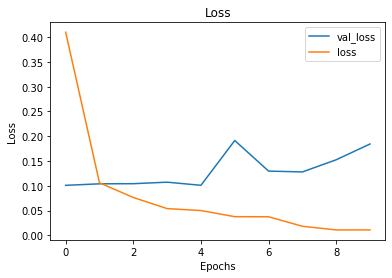

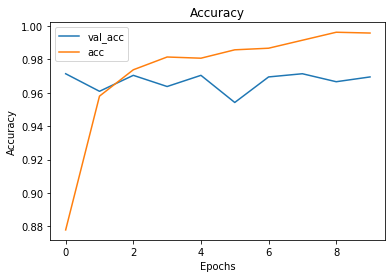

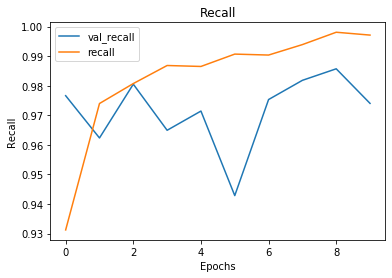

In [56]:
visualize_training_results(cnn3)


In [57]:
results_train = cnn_3.evaluate(X_train, y_train)
results_test = cnn_3.evaluate(test_images, y_test)
print(results_train, results_test) ## loss, accuracy, recall

20/20 [==============================] - 6s 278ms/step - loss: 5.9774 - accuracy: 0.6042 - recall: 0.8051
[0.006480529438704252, 0.9980884194374084, 0.997430145740509] [5.977391242980957, 0.6041666865348816, 0.8051282167434692]


### Model 4: Adding Data Augmentation

In [88]:
# Directory path
train_data_dir = 'CellData/chest_xray/train'
test_data_dir = 'CellData/chest_xray/test'

# Get all the data in the directory data/validation (624 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_data_dir, 
        target_size=(256, 256), batch_size=624)

# Get all the data in the directory data/train (5232 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_data_dir, 
        target_size=(256, 256), batch_size=5232)

#train_labels = np.reshape(train_labels[:,1], (5232,1))
#test_labels = np.reshape(test_labels[:,1], (624,1))
## fix the labels for the images so that normal=0 and pneumonia=1
#y_model = train_labels.T[[1]]
#y_test = test_labels.T[[1]]
#y_model = y_model.T
#y_test = y_test.T
# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
train_images

Found 624 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.


array([[[[0.20784315, 0.20784315, 0.20784315],
         [0.20392159, 0.20392159, 0.20392159],
         [0.23529413, 0.23529413, 0.23529413],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.20784315, 0.20784315, 0.20784315],
         [0.21176472, 0.21176472, 0.21176472],
         [0.227451  , 0.227451  , 0.227451  ],
         ...,
         [0.00392157, 0.00392157, 0.00392157],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.19607845, 0.19607845, 0.19607845],
         [0.20000002, 0.20000002, 0.20000002],
         [0.20392159, 0.20392159, 0.20392159],
         ...,
         [0.02352941, 0.02352941, 0.02352941],
         [0.        , 0.        , 0.        ],
         [0.01176471, 0.01176471, 0.01176471]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]

In [89]:
train_images

array([[[[0.20784315, 0.20784315, 0.20784315],
         [0.20392159, 0.20392159, 0.20392159],
         [0.23529413, 0.23529413, 0.23529413],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.20784315, 0.20784315, 0.20784315],
         [0.21176472, 0.21176472, 0.21176472],
         [0.227451  , 0.227451  , 0.227451  ],
         ...,
         [0.00392157, 0.00392157, 0.00392157],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.19607845, 0.19607845, 0.19607845],
         [0.20000002, 0.20000002, 0.20000002],
         [0.20392159, 0.20392159, 0.20392159],
         ...,
         [0.02352941, 0.02352941, 0.02352941],
         [0.        , 0.        , 0.        ],
         [0.01176471, 0.01176471, 0.01176471]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]

In [58]:
# create validaton set from non-augmented data
X_train, X_val, y_train, y_val = train_test_split(train_images, y_model, test_size=0.20, random_state=765)
# augment data generator
# augment images with given specification
idg_aug = ImageDataGenerator(rescale = 1./255,
                             rotation_range=45,
                             brightness_range = [0.8, 1.2])
# pull images from directory
aug_generator = idg_aug.flow_from_directory(
        train_data_dir, 
        target_size=(256, 256), batch_size=5232)
# create aug data sets
aug_images, aug_labels = next(aug_generator)
# reshape labels
y_aug_model = aug_labels.T[[1]]
y_aug_model = y_aug_model.T
# split augmented images but only keep training set
X_aug, _, y_aug, _ = train_test_split(aug_images, y_aug_model, test_size=0.20, random_state=765)
print(y_aug_model.shape)

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [59]:
# train_labels = np.reshape(train_labels[:,1], (5232,1))
test_labels = np.reshape(test_labels[:,1], (624,1))

In [60]:
test_labels.shape, train_labels.shape

((624, 1), (32,))

In [61]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.20, random_state=123)

In [62]:
model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation = 'relu', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, 3, activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, 3, activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))


In [63]:
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy', 'Recall'])

In [64]:
results = model.fit(X_train,
                    y_train,
                    epochs=10, 
                    validation_data = (X_val, y_val),
                    workers = -1,
                   )


Epoch 1/10
1/1 [==============================] - 0s 309ms/step - loss: 0.7117 - accuracy: 0.2400 - recall: 0.0500 - val_loss: 2.4596e-14 - val_accuracy: 1.0000 - val_recall: 1.0000
Epoch 2/10
1/1 [==============================] - 0s 99ms/step - loss: 8.1843 - accuracy: 0.8000 - recall: 1.0000 - val_loss: 1.6472e-07 - val_accuracy: 1.0000 - val_recall: 1.0000
Epoch 3/10
1/1 [==============================] - 0s 101ms/step - loss: 3.6905 - accuracy: 0.8000 - recall: 1.0000 - val_loss: 0.0206 - val_accuracy: 1.0000 - val_recall: 1.0000
Epoch 4/10
1/1 [==============================] - 0s 100ms/step - loss: 0.7080 - accuracy: 0.8000 - recall: 1.0000 - val_loss: 2.8474 - val_accuracy: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 98ms/step - loss: 2.2001 - accuracy: 0.2000 - recall: 0.0000e+00 - val_loss: 1.0833 - val_accuracy: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 96ms/step - loss: 0.9174 - accu

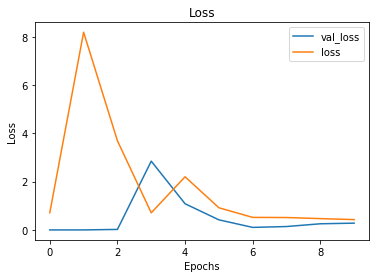

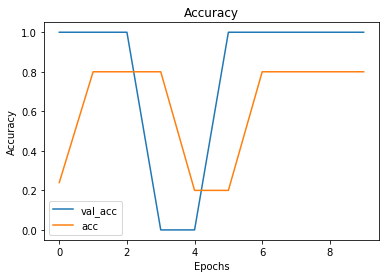

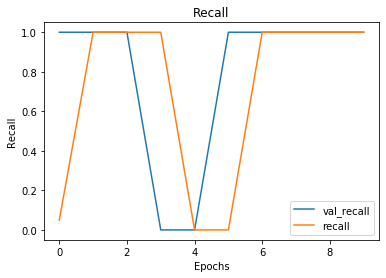

In [65]:
visualize_training_results(results)

In [66]:
results_train = model.evaluate(X_train, y_train)
results_test = model.evaluate(test_images, y_test)
print(results_train, results_test) ## loss, accuracy, recall

20/20 [==============================] - 5s 269ms/step - loss: 0.7020 - accuracy: 0.6250 - recall: 1.0000
[0.3896966576576233, 0.800000011920929, 1.0] [0.7019976377487183, 0.625, 1.0]


This model did worse than before and I can see that there is overfitting and anything past epoch of 2 is unnecessary because thats where I am starting to overfit as it converges to 0 quickly. So I will try the next model with increase in learning rate and also adjust the parameters and add EarlyStopping.

### Model 5: Augmented Data with adjustments

In [67]:
train_generator_aug = ImageDataGenerator(rescale = 1./255,
                                         brightness_range = [0.8, 1.2],
                                         zoom_range=0.3,
                                         rotation_range=15
                                         )

train_generator_aug = train_generator_aug.flow_from_directory(train_data_dir,
                                              target_size = (256,256), 
                                              class_mode='binary')
train_images, train_labels = next(train_generator_aug)
test_images, test_labels = next(test_generator)

Found 5232 images belonging to 2 classes.


In [68]:
#train_labels = np.reshape(train_labels[:,1], (5232,1))
test_labels = np.reshape(test_labels[:,1], (624,1))

In [69]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.20, random_state=123)

In [70]:
model = models.Sequential()
mode.add(ZeroPadding2D(padding=(1, 1), input_shape=train_batches.image_shape))
model.add(layers.Conv2D(32, 3, activation = 'relu', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, 3, activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, 3, activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))


In [71]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001, amsgrad=True),
              metrics=['accuracy', 'Recall'])


In [72]:
results = model.fit(X_train,
                    y_train,
                    epochs=10, 
                    validation_data = (X_val, y_val),
                    workers = -1,
                    callbacks=[EarlyStopping(patience = 3, restore_best_weights=True)]
                   )


Epoch 1/10
1/1 [==============================] - 0s 424ms/step - loss: 0.6924 - accuracy: 0.6000 - recall: 0.7895 - val_loss: 6.0361 - val_accuracy: 0.8571 - val_recall: 1.0000
Epoch 2/10
1/1 [==============================] - 0s 247ms/step - loss: 7.6069 - accuracy: 0.7600 - recall: 1.0000 - val_loss: 2.0732 - val_accuracy: 0.8571 - val_recall: 1.0000
Epoch 3/10
1/1 [==============================] - 0s 244ms/step - loss: 2.5650 - accuracy: 0.7600 - recall: 1.0000 - val_loss: 0.7574 - val_accuracy: 0.1429 - val_recall: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 254ms/step - loss: 0.7102 - accuracy: 0.2800 - recall: 0.0526 - val_loss: 0.5925 - val_accuracy: 0.8571 - val_recall: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 247ms/step - loss: 0.5551 - accuracy: 0.9600 - recall: 1.0000 - val_loss: 0.4837 - val_accuracy: 0.8571 - val_recall: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 246ms/step - loss: 0.4955 - accuracy: 0.7600 - recall

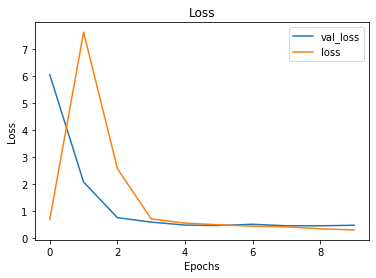

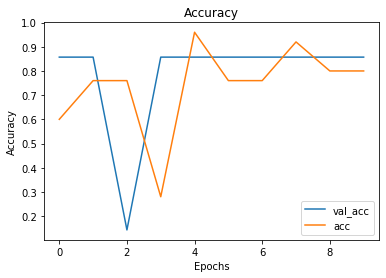

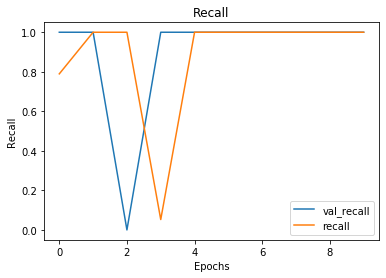

In [73]:
visualize_training_results(results)

In [74]:
results_train = model.evaluate(X_train, y_train)
results_test = model.evaluate(test_images, y_test)
print(results_train, results_test) ## loss, accuracy, recall

20/20 [==============================] - 5s 235ms/step - loss: 0.6765 - accuracy: 0.6074 - recall: 0.9359
[0.290910929441452, 1.0, 1.0] [0.6764827966690063, 0.6073718070983887, 0.9358974099159241]


### Model 6

In [75]:
train_generator_aug = ImageDataGenerator(rescale = 1./255,
                                         brightness_range = [0.8, 1.2],
                                         zoom_range=0.3,
                                         rotation_range=15
                                         )

train_generator_aug = train_generator_aug.flow_from_directory(train_data_dir,
                                              target_size = (256,256), 
                                              class_mode='binary')
train_images, train_labels = next(train_generator_aug)
test_images, test_labels = next(test_generator)

Found 5232 images belonging to 2 classes.


In [76]:
model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation = 'relu', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, 3, activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))


In [77]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.01, amsgrad=False),
              metrics=['accuracy', 'Recall'])


In [78]:
results = model.fit(X_train,
                    y_train,
                    epochs=100, 
                    validation_data = (X_val, y_val),
                    workers = -1,
                    callbacks=[EarlyStopping(patience = 3, restore_best_weights=True)]
                   )


Epoch 1/100
1/1 [==============================] - 1s 529ms/step - loss: 0.6700 - accuracy: 0.7600 - recall: 1.0000 - val_loss: 718.8572 - val_accuracy: 0.8571 - val_recall: 1.0000
Epoch 2/100
1/1 [==============================] - 0s 391ms/step - loss: 886.9318 - accuracy: 0.7600 - recall: 1.0000 - val_loss: 12.2701 - val_accuracy: 0.8571 - val_recall: 1.0000
Epoch 3/100
1/1 [==============================] - 0s 97ms/step - loss: 13.8684 - accuracy: 0.7600 - recall: 1.0000 - val_loss: 45.0716 - val_accuracy: 0.1429 - val_recall: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 388ms/step - loss: 42.3902 - accuracy: 0.2400 - recall: 0.0000e+00 - val_loss: 0.4602 - val_accuracy: 0.8571 - val_recall: 1.0000
Epoch 5/100
1/1 [==============================] - 0s 90ms/step - loss: 0.5464 - accuracy: 0.7600 - recall: 1.0000 - val_loss: 1.1153 - val_accuracy: 0.8571 - val_recall: 1.0000
Epoch 6/100
1/1 [==============================] - 0s 94ms/step - loss: 1.2666 - accuracy: 

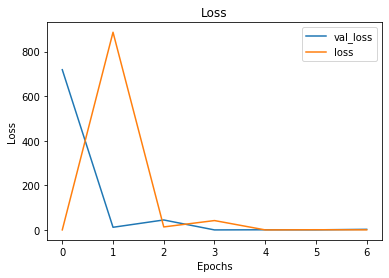

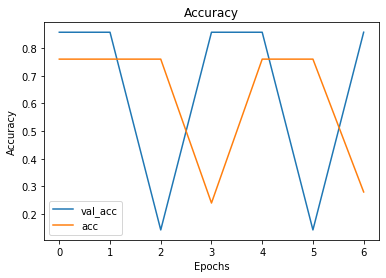

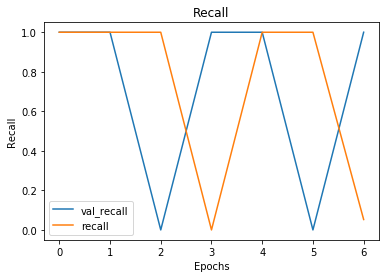

In [79]:
visualize_training_results(results)

In [80]:
results_train = model.evaluate(X_train, y_train)
results_test = model.evaluate(test_images, y_test)
print(results_train, results_test) ## loss, accuracy, recall

20/20 [==============================] - 5s 227ms/step - loss: 0.7237 - accuracy: 0.6250 - recall: 1.0000
[0.5464083552360535, 0.7599999904632568, 1.0] [0.72369384765625, 0.625, 1.0]


## Model with Data Augment (Italo):


In [105]:
# Directory path
train_data_dir = 'CellData/chest_xray/train'
test_data_dir = 'CellData/chest_xray/test'

# Get all the data in the directory data/validation (624 images), and reshape them
test_generator = ImageDataGenerator(1./255).flow_from_directory(
        test_data_dir, 
        target_size=(256, 256), batch_size=624)

# Get all the data in the directory data/train, scale and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_data_dir, 
        target_size=(256, 256), batch_size=5232)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 624 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.


In [106]:
y_model = train_labels.T[[1]]
y_test = test_labels.T[[1]]
y_model = y_model.T
y_test = y_test.T
print(y_model.shape)
print(y_test.shape)

(5232, 1)
(624, 1)


In [107]:
X_train, X_val, y_train, y_val = train_test_split(train_images, y_model, test_size=0.20, random_state=765)


In [108]:
normal_indices = [i for i, x in enumerate(y_train) if x == [0.]]
len(X_train), len(normal_indices)

(4185, 1047)

In [109]:
# augment images with given specification
idg_aug = ImageDataGenerator(rescale = 1./255,
                             rotation_range=45,
                             brightness_range = [0.8, 1.2])

# pull images from directory
aug_generator = idg_aug.flow_from_directory(
        train_data_dir, 
        target_size=(256, 256), batch_size=5232)

# create aug data sets
aug_images, aug_labels = next(aug_generator)

Found 5232 images belonging to 2 classes.


In [110]:
y_aug_model = aug_labels.T[[1]]
y_aug_model = y_aug_model.T
print(y_aug_model.shape)

(5232, 1)


In [111]:
X_aug, _, y_aug, _ = train_test_split(aug_images, y_aug_model, test_size=0.20, random_state=765)


In [112]:
aug_indices = [i for i, x in enumerate(y_train) if x == [0.]]
len(X_aug), len(aug_indices)

(4185, 1047)

In [113]:
normal_indices == aug_indices


True

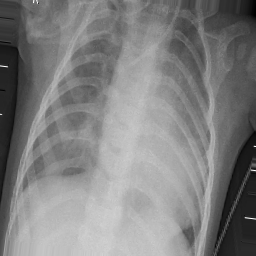

In [114]:
array_to_img(aug_images[520])


In [115]:
model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation = 'relu', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, 3, activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [116]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.01, amsgrad=False),
              metrics=['accuracy', 'Recall'])

In [117]:
results = model.fit(X_aug,
                    y_aug,
                    epochs=100, 
                    validation_data = (X_val, y_val),
                    workers = -1,
                    callbacks=[EarlyStopping(patience = 3, restore_best_weights=True)]
                   )


Epoch 1/100
131/131 [==============================] - 186s 1s/step - loss: 5.5579 - accuracy: 0.7204 - recall: 0.9317 - val_loss: 0.5763 - val_accuracy: 0.7116 - val_recall: 1.0000
Epoch 2/100
131/131 [==============================] - 175s 1s/step - loss: 0.4895 - accuracy: 0.7560 - recall: 0.9558 - val_loss: 0.4953 - val_accuracy: 0.7412 - val_recall: 0.9463
Epoch 3/100
131/131 [==============================] - 176s 1s/step - loss: 2.0125 - accuracy: 0.7697 - recall: 0.8917 - val_loss: 0.9072 - val_accuracy: 0.7116 - val_recall: 1.0000
Epoch 4/100
131/131 [==============================] - 174s 1s/step - loss: 0.4293 - accuracy: 0.8057 - recall: 0.8785 - val_loss: 0.4193 - val_accuracy: 0.7947 - val_recall: 0.8966
Epoch 5/100
131/131 [==============================] - 174s 1s/step - loss: 0.3205 - accuracy: 0.8444 - recall: 0.8953 - val_loss: 0.3162 - val_accuracy: 0.8615 - val_recall: 0.8564
Epoch 6/100
131/131 [==============================] - 172s 1s/step - loss: 0.2965 - accur

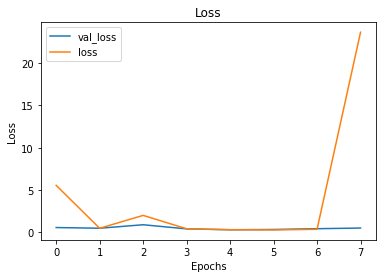

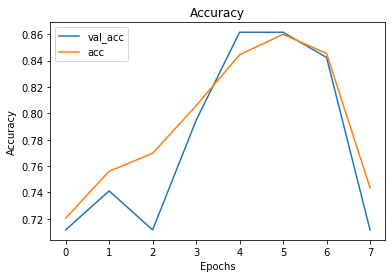

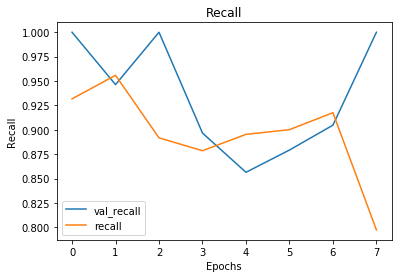

In [118]:
visualize_training_results(results)

In [122]:
results_train = model.evaluate(X_aug, y_aug)
results_test = model.evaluate(test_images, y_val)
print(results_train, results_test) ## loss, accuracy, recall

131/131 [==============================] - 37s 284ms/step - loss: 0.2586 - accuracy: 0.8717 - recall: 0.8521


ValueError: Data cardinality is ambiguous:
  x sizes: 624
  y sizes: 1047
Please provide data which shares the same first dimension.